<div style='background-image: url("../share/Aerial_view_LLNL.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: center ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.8) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%">Visualizing Earthquake Magnitudes:</div>
            <div style="font-size: x-large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)">Amplitude and Distance</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)">2014 South Napa Earthquake</div>
        </div>
    </div>
</div>

Estimated Time: 30 minutes.

This notebook aims to help you explore seismic data resulting from an earthquake.       
Primarily to visualise the idea of amplitude and distance to help make seismic magnitudes more intuitive.       
In the current example we will explore the 2014 South Napa earthquake. Though, you are welcome to play and explore others.

Topics Covered:
- Obtaining Data through ObsPy
- Plotting Earthquake data with Matplotlib
- Querying Event Data

## Visualizing Earthquake Magnitudes Demo

Now that you have learned some Python basics, you can use your skills to analyze some data. 

This notebook will provide some exercises using [Obspy](https://github.com/obspy/obspy/wiki), a Python library used to visualize and analyze seimsographic data.

In [1]:
# These import a few functions and set the figure size and plot styles for our visualizations

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 16, 10

### Event Data

The first step is to find the event. Below, we import the Obspy Client which lets us query for earthquake events. Then we get the UTC date and time for the 2014 South Napa earthquake happened (August 24th, 2014). We are getting the events with at least a magnitude of 6.0. After, we are printing the events in our resulting catalog, with a local projection centered on the San Francisco Bay Area.

In [2]:
import obspy
from obspy.clients.fdsn import Client

client = Client("USGS")
t = obspy.UTCDateTime("2014-08-24T10:20:44.0")  # South Napa earthquake
cat = client.get_events(starttime=t - 100, endtime=t + 3600,
                        minmagnitude=6)

# Print and plot event.
print(cat)
# cat.plot(projection="local", resolution="i");
cat.plot()


1 Event(s) in Catalog:
2014-08-24T10:20:44.070000Z | +38.215, -122.312 | 6.02 mw | manual


/Users/George/anaconda/lib/python3.5/site-packages/obspy/imaging/maps.py:55: UserWarning: Neither basemap nor cartopy installed, map plots will not work.
  warnings.warn(msg)


ImportError: Neither Basemap nor Cartopy could be imported.

### As you can see above, the map is centered on Santa Rosa, showing a 6.0 magnitude event occuring.

### Waveform and Station Data

#### Mass Downloader

ObsPy has a submodule to help download data, called mass downloader. It attempts to offer an API for how seismologists would like to download data. It works in three steps:

1. Define Geographical Domain
2. Define Other Restrictions
3. Launch Download

#### Exercise


##### Part A - Download

Use the mass downloader to download data for a small (there are a lot of stations in this region) geographical region (a circular region with a radius of 1 degree is an example), including the station information, with the mass downloader. Download from 2 minutes before the event to 10 minutes after it and download only `BHZ` (Broadband) channels.

In [3]:
import obspy
from obspy.clients.fdsn.mass_downloader import CircularDomain, \
    Restrictions, MassDownloader

In [4]:
# First, define a domain.
domain = CircularDomain(latitude=cat[0].origins[0].latitude,
                        longitude=cat[0].origins[0].longitude,
                        minradius=0.25, maxradius=5.0)

# Second, define some additional restrictions.
restrictions = Restrictions(starttime=cat[0].origins[0].time - 0.5 * 60,
                            endtime=cat[0].origins[0].time + 5 * 60,
                            minimum_interstation_distance_in_m=100E3,channel="BHZ",)

# If you leave the providers empty it will loop through
# all data centers it knows.
# It will prefer data from the first providers.
mdl = MassDownloader(providers=["SCEDC", "NCEDC", "IRIS"])

# Finally launch it.
mdl.download(domain, restrictions,
             mseed_storage="waveforms",
             stationxml_storage="stations")

[2017-10-31 21:26:37,305] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for SCEDC, NCEDC, IRIS.
[2017-10-31 21:26:42,521] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 3 client(s): SCEDC, NCEDC, IRIS.
[2017-10-31 21:26:42,522] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2017-10-31 21:26:42,523] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - Requesting unreliable availability.
[2017-10-31 21:26:42,680] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - No data available for request.
[2017-10-31 21:26:42,681] - obspy.clients.fdsn.mass_downloader - INFO: Client 'SCEDC' - No data available.
[2017-10-31 21:26:42,682] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2017-10-31 21:26:42,682] - obspy.clients.fdsn.mass_downloader - INFO: Client 'NCEDC' - Requesting unreliable availability.
[2017-10-31 21:26:43,366] - obspy.clients.fdsn.m

[2017-10-31 21:26:55,808] - obspy.clients.fdsn.mass_downloader - INFO: Client 'NCEDC' - Successfully downloaded 'stations/TA.M02C.xml'.
[2017-10-31 21:26:55,868] - obspy.clients.fdsn.mass_downloader - INFO: Client 'NCEDC' - Successfully downloaded 'stations/BK.MOBB.xml'.
[2017-10-31 21:26:56,630] - obspy.clients.fdsn.mass_downloader - INFO: Client 'NCEDC' - Successfully downloaded 'stations/BK.FARB.xml'.
[2017-10-31 21:26:56,667] - obspy.clients.fdsn.mass_downloader - INFO: Client 'NCEDC' - Successfully downloaded 'stations/BK.BDM.xml'.
[2017-10-31 21:26:56,701] - obspy.clients.fdsn.mass_downloader - INFO: Client 'NCEDC' - Successfully downloaded 'stations/BK.TSCN.xml'.
[2017-10-31 21:26:57,649] - obspy.clients.fdsn.mass_downloader - INFO: Client 'NCEDC' - Successfully downloaded 'stations/BK.HATC.xml'.
[2017-10-31 21:26:57,650] - obspy.clients.fdsn.mass_downloader - INFO: Client 'NCEDC' - Successfully downloaded 'stations/TA.N02D.xml'.
[2017-10-31 21:26:57,651] - obspy.clients.fdsn.ma

[2017-10-31 21:27:02,434] - obspy.clients.fdsn.mass_downloader - INFO: Deleting StationXMl file 'stations/BK.MNRC.xml'. Reason: Minimum distance filtering.
[2017-10-31 21:27:02,435] - obspy.clients.fdsn.mass_downloader - INFO: Deleting MiniSEED file 'waveforms/TA.O03E..BHZ__20140824T102014Z__20140824T102544Z.mseed'. Reason: Minimum distance filtering.
[2017-10-31 21:27:02,436] - obspy.clients.fdsn.mass_downloader - INFO: Deleting StationXMl file 'stations/TA.O03E.xml'. Reason: Minimum distance filtering.
[2017-10-31 21:27:02,438] - obspy.clients.fdsn.mass_downloader - INFO: Deleting MiniSEED file 'waveforms/BK.BRIB.00.BHZ__20140824T102014Z__20140824T102544Z.mseed'. Reason: Minimum distance filtering.
[2017-10-31 21:27:02,439] - obspy.clients.fdsn.mass_downloader - INFO: Deleting StationXMl file 'stations/BK.BRIB.xml'. Reason: Minimum distance filtering.
[2017-10-31 21:27:02,440] - obspy.clients.fdsn.mass_downloader - INFO: Deleting MiniSEED file 'waveforms/BK.MOBB.00.BHZ__20140824T1020

{'IRIS': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x111556978>,
 'NCEDC': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x111560278>,
 'SCEDC': <obspy.clients.fdsn.mass_downloader.download_helpers.ClientDownloadHelper at 0x111556550>}

##### Part B - Plot Stations

Plot the stations and the event in a single map. 
The code below reads through the stations file and reads the inventory at each file name. Then the inventory is plotted with a local projection and then a title is added to the map.

In [5]:
import glob

# In the master you don't have to do the looping.
for i,filename in enumerate(glob.glob("stations/*.xml")):
    if i==0:
        inv = obspy.read_inventory(filename)
    else:
        inv+=obspy.read_inventory(filename)

fig = inv.plot(projection="local", resolution='i',show=False, size=70)
fig = cat.plot(fig=fig,projection="local", resolution='i',show=False, title='Stations Available for South Napa Quake');

plt.show()

ImportError: Neither Basemap nor Cartopy could be imported.

##### Part C - Process Data

This will filter the data and check there are no gaps etc.     
Don't worry about this.

In [24]:
import glob
import os
import numpy as np

inv = obspy.Inventory(networks=[], source="")

# First read all station files.
for filename in glob.glob("./stations/*.xml"):
    inv += obspy.read_inventory(filename)
    
# Now read the waveform files.
st = obspy.read("./waveforms/*.mseed")

st.remove_response(inventory=inv, water_level=60)
st.detrend("linear")
st.taper(max_percentage=0.05)
st.filter("bandpass", freqmin=0.001, freqmax=0.1,
          zerophase=True, corners=6)

max_starttime = max(tr.stats.starttime for tr in st)
min_endtime = min(tr.stats.endtime for tr in st)
npts = int((min_endtime - max_starttime)  / 2.0)

for tr in st:
    tr.data = np.require(tr.data,
                         requirements=["C_CONTIGUOUS"])
    
# Remove instrument response
st.remove_response(inventory=inv)

st.interpolate(sampling_rate=0.5, method="lanczos",
               starttime=max_starttime, npts=npts, a=12)

36 Trace(s) in Stream:

7D.G01D..BHZ | 2014-08-24T10:20:44.294538Z - 2014-08-24T10:25:32.294538Z | 0.5 Hz, 145 samples
...
(34 other traces)
...
Z5.GB281..BHZ | 2014-08-24T10:20:44.294538Z - 2014-08-24T10:25:32.294538Z | 0.5 Hz, 145 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

In [33]:
import pprint
pprint.pprint("""Possible stations below.
Stations (36):
G01D (WHOI OBS ID S85)
G03D (WHOI OBS ID T111)
G05D (WHOI OBS ID T112)
G21D (WHOI OBS ID T106)
G33D (SIO OBS ID G33D)
M16D (SIO OBS ID M16D)
BDM (Black Diamond Mines Park, Antioch, CA, USA)
BKS (Byerly Seismographic Vault, Berkeley, CA, USA)
CMB (Columbia College, Columbia, CA, USA)
FARB (Farallon Islands, CA, USA)
HATC (Hat Creek Radio Astronomy Obs., Cassel, CA, USA)
HELL (Rademacher Property, Miramonte, CA, USA)
HOPS (Hopland Research and Extension Center, Hopland, CA)
JCC (Jacoby Creek, Bayside, CA, USA)
MOD (Modoc Plateau, CA, USA)
ORV (Oroville Dam, Oroville, CA, USA)
RAMR (Ramage Ranch, Paso Robles, CA, USA)
SAO (San Andreas Geophysical Obs., Hollister, CA, USA)
SUTB (Sutter Buttes, CA, USA)
THIS (South End of Cholame Valley, Shandon, CA, USA)
WDC (Whiskeytown Dam, Whiskeytown, CA, USA)
YBH (Yreka Blue Horn Mine, Yreka, CA, USA)
LRL (Laurel Mtn)
MLAC (Mammoth)
MPP (Mcpherson Peak)
OSI (Osito Audit: Castaic Lake)
SCZ2 (Santa Cruz Island 2)
SPG2 (Springville 2)
NV31 (NVAR Array Site 31, Mina, NV, USA)
K04D (Chiloquin, OR, USA)
L02E (Cave Junction, OR, USA)
M02C (Callahan, CA, USA)
O02D (Mt. Diablo Meridian, CA, USA)
DBO (Dodson Butte, OR, USA (UO CREST BB SMO))
TPNV (Topopah Spring, Nevada, USA)
GB281 (SIO OBS ID GB281))""")

('Possible stations below.\n'
 'Stations (36):\n'
 'G01D (WHOI OBS ID S85)\n'
 'G03D (WHOI OBS ID T111)\n'
 'G05D (WHOI OBS ID T112)\n'
 'G21D (WHOI OBS ID T106)\n'
 'G33D (SIO OBS ID G33D)\n'
 'M16D (SIO OBS ID M16D)\n'
 'BDM (Black Diamond Mines Park, Antioch, CA, USA)\n'
 'BKS (Byerly Seismographic Vault, Berkeley, CA, USA)\n'
 'CMB (Columbia College, Columbia, CA, USA)\n'
 'FARB (Farallon Islands, CA, USA)\n'
 'HATC (Hat Creek Radio Astronomy Obs., Cassel, CA, USA)\n'
 'HELL (Rademacher Property, Miramonte, CA, USA)\n'
 'HOPS (Hopland Research and Extension Center, Hopland, CA)\n'
 'JCC (Jacoby Creek, Bayside, CA, USA)\n'
 'MOD (Modoc Plateau, CA, USA)\n'
 'ORV (Oroville Dam, Oroville, CA, USA)\n'
 'RAMR (Ramage Ranch, Paso Robles, CA, USA)\n'
 'SAO (San Andreas Geophysical Obs., Hollister, CA, USA)\n'
 'SUTB (Sutter Buttes, CA, USA)\n'
 'THIS (South End of Cholame Valley, Shandon, CA, USA)\n'
 'WDC (Whiskeytown Dam, Whiskeytown, CA, USA)\n'
 'YBH (Yreka Blue Horn Mine, Yreka, CA, 

##### Part D - Choose stations and compare amplitudes

**Exercise:** Pick three stations from the above plot.    

       
Try stations:     
1) Roughly in a line and at different distances       
2) Not in a line at the same distance

In [37]:
# Modify the station labels here before running the cell below this one
StationA = 'BKS'
StationB = 'ORV'
StationC = 'MOD'

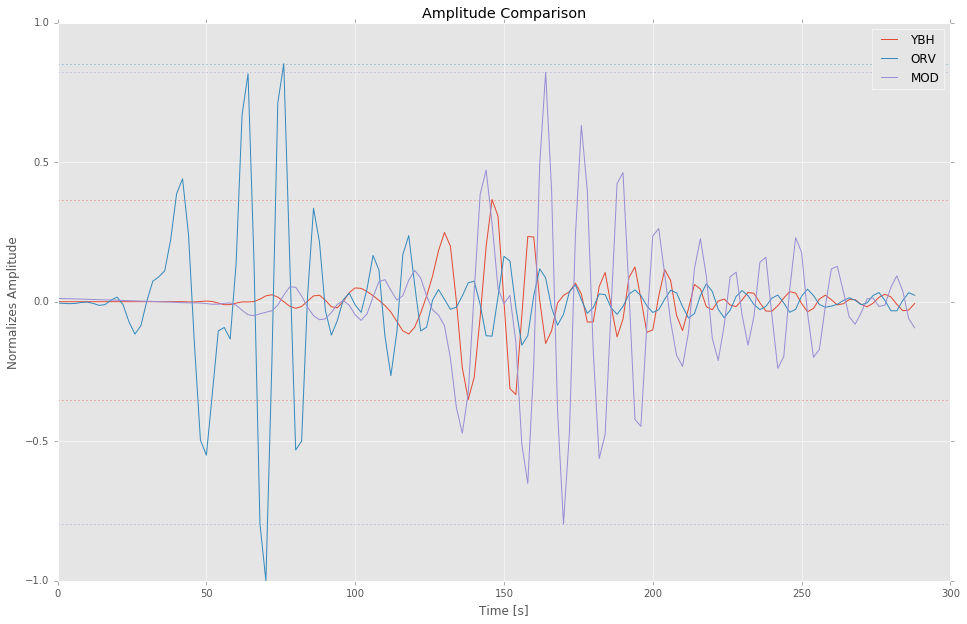

In [38]:
fig,ax = plt.subplots(1,1)
Stations = [StationA,StationB,StationC]

# Find maximum amplitude for normailzation
max_amp = 0
for station in Stations: 
    max_amp_temp = max(abs(st.select(station=station)[0].data))
    max_amp = max(max_amp_temp, max_amp)
    
for station in Stations: 
    data = st.select(station=station)[0].data/max_amp# normalize data
    trace = ax.plot(st.select(station=station)[0].times(),data, label=station)
    color = trace[0].get_color()
    ax.axhline(y=max(data), xmin=min(st.select(station=station)[0].times()), xmax=max(st.select(station=station)[0].times()), ls=':', c=color, alpha=0.7)
    ax.axhline(y=min(data), xmin=min(st.select(station=station)[0].times()), xmax=max(st.select(station=station)[0].times()), ls=':', c=color, alpha=0.7)
    

ax.legend()
ax.set_ylim([-1,1])
ax.set_title('Amplitude Comparison')
ax.set_ylabel('Normalizes Amplitude')
ax.set_xlabel('Time [s]')

Notebook developed by Alexander Robson, George Khalilieh

Data Science Modules: http:/data.berkeley.edu/education/modules